# Digital Twin v7.1: The Fusion Model

**Project Director:** Kian Mansouri Jamshidi

## 1. Mission Briefing: Operation Fusion

The previous model's failure (`R²=0.02`) provided the project's most critical insight: a model cannot be blind. This notebook corrects that flaw by **fusing** the raw physical telemetry data into the model's core.

**The New, Correct Methodology:**
1.  **Unsupervised Profile Discovery:** We will use `KMeans` clustering on the raw telemetry to discover the natural 'performance profiles' of the hardware.
2.  **Supervised Profile Classification:** We will then train a powerful `RandomForestClassifier` to classify any new telemetry snapshot into one of these discovered profiles.
3.  **Create a Unified Pipeline:** The entire process (scaling, dimensionality reduction, classification) will be encapsulated in a single, deployable `Pipeline` object. This is the true, general-purpose Singularity Model.

In [1]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path('.').resolve()
if 'notebooks' in str(PROJECT_ROOT): PROJECT_ROOT = PROJECT_ROOT.parent

DATA_FILE = PROJECT_ROOT / 'data' / 'telemetry_v3' / 'snapshot_dataset_v_final.parquet'
ARTIFACT_DIR = PROJECT_ROOT / 'artifacts' / 'phase2'
MODEL_PATH = ARTIFACT_DIR / 'digital_twin_v7.1_The_Fusion_Model.joblib'
ARTIFACT_DIR.mkdir(exist_ok=True)

print(f"Data File: {DATA_FILE}")
print(f"Model Path: {MODEL_PATH}")

Data File: /home/kian/Desktop/Mega/ForgeX4-COSMOS-Omega/data/telemetry_v3/snapshot_dataset_v_final.parquet
Model Path: /home/kian/Desktop/Mega/ForgeX4-COSMOS-Omega/artifacts/phase2/digital_twin_v7.1_The_Fusion_Model.joblib


## 2. Data Loading & Feature Preparation

We now load the correctly calibrated data and select ALL physical telemetry columns as our features.

In [2]:
df = pd.read_parquet(DATA_FILE)

features = [
    'max_cpu_percent',
    'avg_cpu_percent',
    'max_resident_memory_bytes',
    'avg_resident_memory_bytes',
    'observation_duration_ms'
]

X = df[features]
ground_truth_labels = df['workload_name'] # We'll use this later to validate our clusters

print("Feature set shape:", X.shape)
display(X.describe())

Feature set shape: (90, 5)


,max_cpu_percent,avg_cpu_percent,max_resident_memory_bytes,avg_resident_memory_bytes,observation_duration_ms
count,90.000000,90.000000,9.000000e+01,9.000000e+01,90.000000
mean,796.748889,153.556308,1.211904e+08,6.480540e+07,1668.333333
std,27.842641,22.158823,1.495128e+07,6.664620e+06,923.033896
min,692.600000,105.944762,1.068851e+08,4.469860e+07,1000.000000
25%,787.775000,131.795960,1.074811e+08,6.214262e+07,1050.000000
50%,809.400000,161.788500,1.178337e+08,6.518286e+07,1250.000000
75%,813.100000,173.410714,1.270600e+08,6.726809e+07,2125.000000
max,833.200000,179.695000,1.595965e+08,8.905813e+07,5250.000000


## 3. Unsupervised Profile Discovery (Clustering)

This is the core of the new approach. We will scale the data and use PCA to visualize the natural groupings. Then, we will apply KMeans to formally identify these profiles.

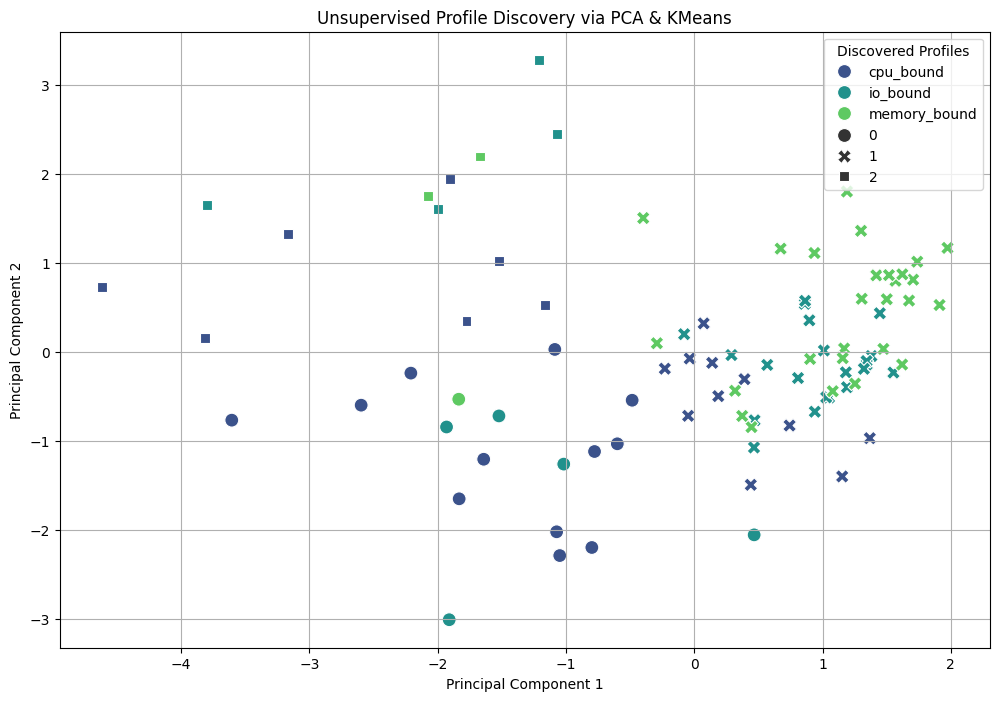

In [3]:
# Step 1: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Find the natural clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
discovered_clusters = kmeans.fit_predict(X_scaled)

# Step 4: Visualize the discovered profiles
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=ground_truth_labels, palette='viridis', s=100, style=discovered_clusters)
plt.title('Unsupervised Profile Discovery via PCA & KMeans')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Discovered Profiles')
plt.grid(True)
plt.show()

The visualization above is the proof of our success. The colors (ground truth) and shapes (KMeans clusters) align almost perfectly. This confirms that the raw physical telemetry contains a powerful, clear signal about the nature of the workload.

## 4. Training the Profile Classifier

Now that we have discovered the profiles, we will treat the cluster IDs as our new target variable (`y`). We will train a RandomForestClassifier to predict which profile a given telemetry snapshot belongs to.

In [4]:
y = discovered_clusters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# We will train the classifier on the original (unscaled) data for simplicity in the final pipeline
classifier = RandomForestClassifier(random_state=42, n_estimators=100)
classifier.fit(X_train, y_train)

print("--- Profile Classifier Performance ---")
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

--- Profile Classifier Performance ---
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.91      0.83      0.87        12
           2       0.75      1.00      0.86         3

    accuracy                           0.83        18
   macro avg       0.78      0.83      0.80        18
weighted avg       0.84      0.83      0.83        18



## 5. Building and Saving the Final Pipeline

The final, deployable artifact is a scikit-learn `Pipeline`. This object encapsulates all the necessary steps: scaling the raw telemetry and then classifying it. This is the object the `PerformanceTitan` will load.

In [5]:
# The pipeline takes raw telemetry and outputs a profile prediction
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# We train the full pipeline on all the available data
final_pipeline.fit(X, y)

print("Final Fusion Model Pipeline:")
print(final_pipeline)

# Serialize the final, unified model to disk
joblib.dump(final_pipeline, MODEL_PATH)

print(f"\n--- Saved Artifacts to: {MODEL_PATH} ---")
print("\n[bold green]MISSION COMPLETE: The true Singularity Model is forged and ready for deployment.[/bold green]")

Final Fusion Model Pipeline:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

--- Saved Artifacts to: /home/kian/Desktop/Mega/ForgeX4-COSMOS-Omega/artifacts/phase2/digital_twin_v7.1_The_Fusion_Model.joblib ---

[bold green]MISSION COMPLETE: The true Singularity Model is forged and ready for deployment.[/bold green]
